In [1]:
import numpy as np
import scipy as sp
from scipy.special import binom
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import mpnum as mp
import sklearn
import plotly.offline as ply
from sklearn import svm
from numba import autojit
#%matplotlib notebook

# Sweeeeeping!!

Define Ausiliar functions

In [2]:
@autojit
def feature_map(x):
    """Local feature map"""
    
    x_arr = 0.5 * np.pi * np.array([x]*d)
    s = np.arange(d)
    return np.sqrt(binom([d-1]*d,s)) * np.power(np.cos(x_arr), d-1-s) * np.power(np.sin(x_arr), s)

@autojit
def Tdelta(l):
    """Create a tensor kronecker delta"""
    return mp.MPArray.from_kron([np.array([1-l,l])])

@autojit
def evaluate(Tweight, x, y):
    xy_mpa = mp.MPArray.from_kron([feature_map(x),feature_map(y)]).group_sites(2) # feature tensor
    Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1]))
    W0 = mp.dot(Tf, Tdelta(0)).to_array()
    W1 = mp.dot(Tf, Tdelta(1)).to_array()
    Wdiff = W0 - W1
    Wsum = W0 + W1
    return Wdiff * Wsum / np.abs(Wdiff * Wsum)

def plot_tn_decision_function(Tweight, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] =evaluate(Tweight,xi,yj)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.c_[xi.ravel(), yj.ravel()])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

Define sweeping algorithm

In [3]:
@autojit
def update2sites(data, label, Tweight):    
    TdeltaB = mp.MPArray.from_kron([np.array([0]*2), np.array([0]*d), np.array([0]*d)]).group_sites(3) #null tensor deltaB (single size)
    for idx in range(len(data)):
        # create the full feature map
        xy_mpa = mp.MPArray.from_kron([feature_map(data[idx][0]),feature_map(data[idx][1])]).group_sites(2) # feature tensor
        # tensot product between the weights and the feature map
        Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1])) # the last two physical legs are of Tweight are contracted with the feature tensor
        Tcoef = (Tdelta(label[idx]) - Tf)
        Ttemp = mp.MPArray.from_kron([Tcoef.to_array(), xy_mpa.to_array()]).group_sites(2)
        TdeltaB = TdeltaB + Ttemp
    
    Tweight = Tweight + alpha * TdeltaB
    return Tweight

# Classify data

## Two overlapping  gaussians

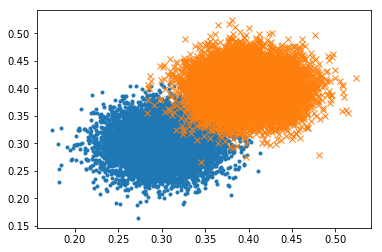

In [4]:
mean1=[0.3,0.3]
cov1=[[0.001,0],[0,0.001]]
mean2=[0.4,0.4]
cov2=[[0.001,0],[0,0.001]]
class0=np.random.multivariate_normal(mean1, cov1, 10000)
class1=np.random.multivariate_normal(mean2, cov2, 10000)

f1=plt.figure()
plt.plot(class0.T[0],class0.T[1],".")
plt.plot(class1.T[0],class1.T[1],"x")
plt.show()

Prepare training data

In [5]:
# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata], class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [6]:
d = 2 # local dimension
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [7]:
numsteps = 100
alpha = 5e-4 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

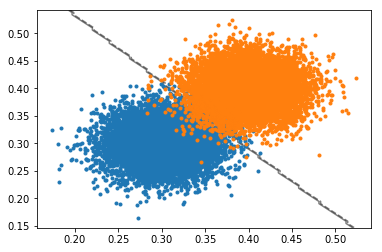

In [8]:
point_to_plot = 10000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [9]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(train_data, label)
model.score(train_data, label)

0.98950000000000005

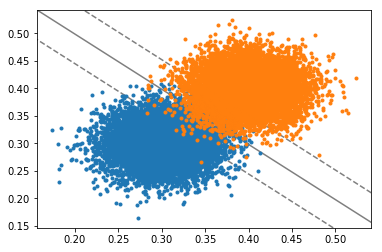

In [10]:
point_to_plot = 10000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

## Semi circular uniform distributions

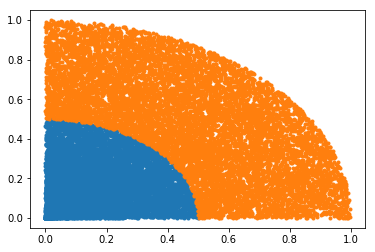

In [11]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 0.5*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 0.5*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)])
y0 = np.array([class0_radius*np.sin(class0_phase)])
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)])
y1 = np.array([class1_radius*np.sin(class1_phase)])
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

Prepare training data

In [12]:
# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [13]:
d = 3
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [14]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

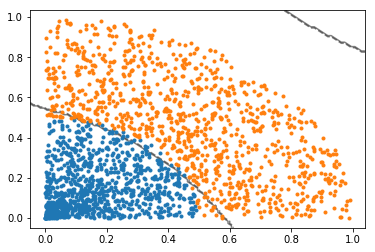

In [15]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [16]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='poly', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(train_data, label)
model.score(train_data, label)

0.98599999999999999

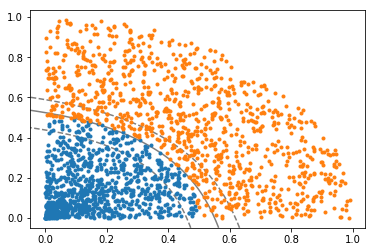

In [17]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

## Circular distribution

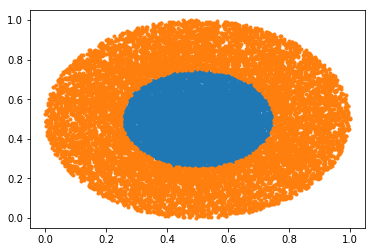

In [18]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 2*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 2*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)]) * 0.5 + 0.5
y0 = np.array([class0_radius*np.sin(class0_phase)]) * 0.5 + 0.5
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)]) * 0.5 + 0.5
y1 = np.array([class1_radius*np.sin(class1_phase)]) * 0.5 + 0.5
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

Prepare training data

In [19]:
# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [20]:
d = 3
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [21]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

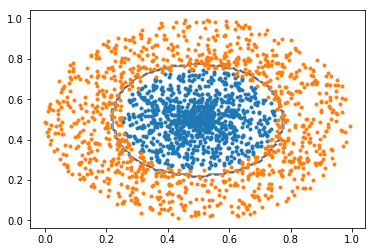

In [22]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [23]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='rbf', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(train_data, label)
model.score(train_data, label)

0.98850000000000005

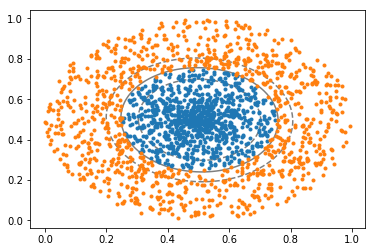

In [24]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()

## Spiral distributions

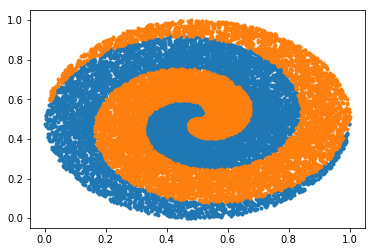

In [25]:
max_data = 10000
max_angle = 3*np.pi
theta = np.random.uniform(0, max_angle, max_data)

class0_phase = np.random.uniform(0, np.pi, max_data)
class1_phase = np.random.uniform(0, -np.pi, max_data)

x0 = np.array([theta * np.cos(theta + class0_phase)]) * 0.5 / max_angle + 0.5
y0 = np.array([theta * np.sin(theta + class0_phase)]) * 0.5 / max_angle + 0.5
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([theta * np.cos(theta + class1_phase)]) * 0.5 / max_angle + 0.5
y1 = np.array([theta * np.sin(theta + class1_phase)]) * 0.5 / max_angle + 0.5
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

Prepare training data

In [26]:
# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

### Tensor network

Generate and update a random tensor weight using gradient descent steps

In [27]:
d = 70
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

In [28]:
numsteps = 100
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

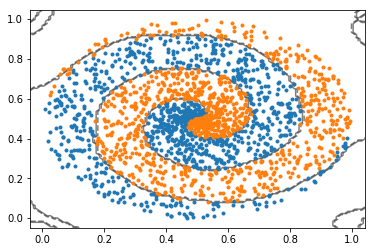

In [29]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

### SVM

In [30]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='rbf', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(train_data, label)
model.score(train_data, label)

0.58199999999999996

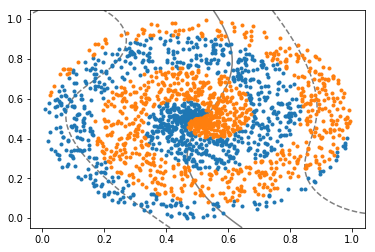

In [31]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_svc_decision_function(model)
plt.show()